### Carregando as Bibliotecas

In [10]:
! pip install lightgbm
! pip install xgboost

In [11]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [12]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [13]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

In [14]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Arquivos_EUA

In [16]:
X= pd.read_excel(r'X.xlsx')

In [17]:
output= pd.read_excel(r'yeol.xlsx', header=0)

In [18]:
X =X.fillna(0.001)

In [19]:
X.head(2)

,pibe_capita,pibe_areae,pope_areae,pibe_GWe,GWe_pope
0,0.046529,1.739276,37.380099,0.001599,29.099337
1,0.074343,0.113787,1.530579,0.008958,8.298660


### Eolico

In [20]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,output,test_size =0.25, random_state=1234)

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

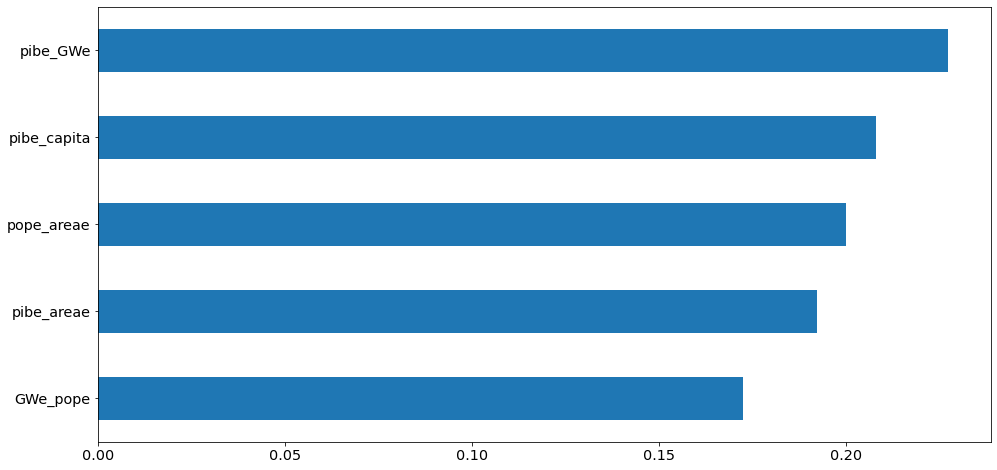

In [22]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10).sort_values().plot.barh())

### Algoritmo Referência = Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [24]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10,11,12],
              "max_features":['auto'],
              'max_depth':[5,10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.1s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [25]:
random_rf.best_params_

{'n_estimators': 2,
 'min_samples_split': 6,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 5,
 'max_features': 'auto',
 'max_depth': 30}

In [26]:
m_rf=RandomForestRegressor(n_estimators= 2,
 min_samples_split = 6,
 min_samples_leaf = 10,
 max_leaf_nodes = 5,
 max_features ='auto',
 max_depth = 30)

In [27]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [28]:
y_rf= yrf.predict(X_test)

### Avaliação dos Erros_Solar

In [29]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error # MSE
# RMSE = mean_squared_error(y_test,y_pred,squared=False) 
from sklearn.metrics import mean_absolute_error
import numpy as np
# MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
from sklearn.metrics import mean_squared_log_error

In [30]:
c=np.mean(y_train)
print(round(c,3))

eole    821418.43
dtype: float64


In [31]:
R2 = r2_score(y_test,y_rf)
mse_rf = mean_squared_error(y_test, y_rf)
rmse_rf = mse_rf**0.5
mae_rf =  mean_absolute_error(y_test, y_rf)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_rf,3))
print('RMSE =', round(rmse_rf,3))
print('MAE = ', round(mae_rf,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.257
MSE = 239053592552.825
RMSE = 488931.071
MAE =  390143.753


In [32]:
# R2 ajustado -- ponderação entre os fatores mais relevantes
def adjusted_r2(y_test, y_rf,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_rf)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
a= round(adjusted_r2(y_test,y_rf,X_train),3)
print(a)

-1.155


In [33]:
y_test=np.array(y_test)

In [34]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-4451385.5
18994928.4


In [35]:
a=np.mean(y_train) #teste média y_train
a
a = [a]*len(y_test)

In [36]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_rf = mse_rf/mse_m
print(round(mse_m,3), round(mse_rf,3))
print(round(r_rf,3))

596535541145.707 239053592552.825
0.401


### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [37]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [38]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [39]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [40]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(X_train, y_train)
 # XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(X_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(X_train, y_train)

print('****** Regressao_Pronta  *********')

****** Regressao_Pronta  *********


In [41]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [42]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   11.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[16:28:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [43]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,output,cv=10)
score_lgb=cross_val_score(lgb,X,output,cv=10)
score_xgb=cross_val_score(xgb,X,output,cv=10)
score_ada=cross_val_score(ada,X,output,cv=10)

### Gradient Boosting

In [44]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.2, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [69]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.5, loss='ls', max_depth= 8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [70]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.5, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [71]:
y_gbr = m_gbr.predict(X_test)

In [72]:
mse_gbr = round(mean_squared_error(y_test, y_gbr),3)
print(mse_gbr)

441867017613.721


In [73]:
errop2= (y_test - y_gbr)*100/y_test
a = np.mean(errop2)
print(round(a,3))
# em porcentagem

-5638987.749


In [74]:
R2 = r2_score(y_test,y_gbr)
mse_gbr = mean_squared_error(y_test, y_gbr)
rmse_gbr = mse_gbr**0.5
mae_gbr =  mean_absolute_error(y_test, y_gbr)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_gbr,3))
print('RMSE =', round(rmse_gbr,3))
print('MAE = ', round(mae_gbr,3))
# print('MSLE =', round(msle_rf,3))

R2 = -1.323
MSE = 441867017613.721
RMSE = 664730.786
MAE =  650633.978


In [75]:
def adjusted_r2(y_test, y_gbr,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_gbr)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
c = round(adjusted_r2(y_test,y_gbr,X_train),3)
print(c)

-2.983


In [76]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_gbr = mse_gbr/mse_m
print(round(mse_m,3), round(mse_gbr,3))
print(round(r_gbr,3))

596535541145.707 441867017613.721
0.741


### Light Gradient Boosting

In [77]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6, gamma=0.3, importance_type='split',
              learning rate=0.4, learning_rate=0.001, max depth=3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=7,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [96]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.1, importance_type='split',
              learning_rate=0.5, max_depth=4,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [97]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.1, importance_type='split',
              learning_rate=0.5, max_depth=4, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [98]:
y_lgb = m_lgb.predict(X_test)

In [99]:
mse_lgb = round(mean_squared_error(y_test, y_lgb),3)
print(mse_lgb)

596535534958.472


In [100]:
errop2= (y_test - y_lgb)*100/y_test
# em porcentagem

In [101]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_lgb = mse_lgb/mse_m
print(round(mse_m,3), round(mse_lgb,3))
print(round(r_lgb,3))

596535541145.707 596535534958.472
1.0


### XGBoosting

In [102]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.2, learning_rate=0.001, max depth=11,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [131]:
from xgboost import XGBRegressor
m_xgb= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01,
             max_delta_step=0, max_depth=2, min_child_weight=3,
             missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [132]:
m_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [133]:
y_xgb= m_xgb_1.predict(X_test)

In [134]:
mse_xgb = round(mean_squared_error(y_test, y_xgb_1),3)
print (mse_xgb_1)

151769124148.627


In [135]:
errop2= (y_test - y_xgb)*100/y_test
# em porcentagem

In [136]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_xgb = mse_xgb/mse_m
print(round(mse_m,3), round(mse_xgb,3))
print(round(r_xgb,3))

596535541145.707 151769124148.627
0.254


### Adaptative Boosting

In [121]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.001, loss='linear', n_estimators=40,
                  random

In [122]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_state=None)

In [123]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_

In [124]:
y_ada = m_ada.predict(X_test)

In [125]:
mse_ada = round(mean_squared_error(y_test, y_ada),8)
print (mse_ada)

265789892421.02203


In [126]:
errop2= (y_test - y_ada)*100/y_test
# em porcentagem

In [127]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_ada = mse_ada/mse_m
print(round(mse_m,3), round(mse_ada,3))
print(round(r_ada,3))

596535541145.707 265789892421.022
0.446


In [137]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb,mse_ada]
r=[r_rf,r_gbr,r_lgb,r_xgb,r_ada]
lista = list(zip(mse,r))
d = pd.DataFrame(lista, columns =['MSE','Razão'], index=models)
d

,MSE,Razão
Random_Forest,2.390536e+11,0.400737
GradientBoost,4.418670e+11,0.740722
LightGBM,5.965355e+11,1.000000
XGBoost,1.517691e+11,0.254418
AdaBoost,2.657899e+11,0.445556


### Predição dados Brasil

### Composição do arquivo de saída¶

In [140]:
entb= pd.read_excel(r'Xb.xlsx', header=0)
entb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
pibe_capita    26 non-null float64
pibe_areae     26 non-null float64
pope_areae     26 non-null float64
pibe_GWe       26 non-null float64
GWe_pope       26 non-null float64
dtypes: float64(5)
memory usage: 1.1 KB


In [141]:
outputb= m_xgb.predict(entb)

In [142]:
outb=pd.DataFrame(data=outputb, columns=['Prev'])
outb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
Prev    26 non-null float32
dtypes: float32(1)
memory usage: 232.0 bytes


In [143]:
br= pd.read_excel(r'br_estado.xlsx', header=0)

In [144]:
br=br.drop(columns=['PIB em 2017 (1.000.000 R$)','Área (km2)','Geração de energia GW.h','População'])
br.head(1)

,Unidades da Federação
0,Acre


In [145]:
br = br.rename({'Unidades da Federação': 'Estado'}, axis = 1)

In [146]:
br = pd.DataFrame(data=br)

In [147]:
br1 = pd.DataFrame(data=outputb, columns=["Previsão"])
br1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
Previsão    26 non-null float32
dtypes: float32(1)
memory usage: 232.0 bytes


In [148]:
prv = pd.concat([br, br1], axis=1, sort=False)

In [149]:
prv.head(30)

,Estado,Previsão
0,Acre,451004.375000
1,Alagoas,143861.781250
2,Amapá,451004.375000
3,Amazonas,451004.375000
4,Bahia,317060.968750
5,Ceará,142037.750000
6,Espírito Santo,110828.906250
7,Goiás,360473.593750
8,Maranhão,451004.375000
9,Mato Grosso,451004.375000
